# Week 5 - Classifying Meanings & Documents

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
root_dir = "/content/drive/My Drive/"
data_dir = '/content/drive/MyDrive/Chicago/Academics/2022 Winter/Soci 40133 Content Analysis/Homework-Notebooks/data'
os.chdir(data_dir)

In [ ]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain. Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [ ]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#content/drive/MyDrive//data/pyAnno/testdata_numerical.txt"
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
# make entire array into categorical variables, 1, 2, 3, 4 -> 1st category is anotated as 0, 2nd as 1, 3rd as 2, 4th as 3, -1 as missing value
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [ ]:
x

array([[ 2.,  3.,  4., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 3.,  3.,  2., ..., -1., -1., -1.],
       ...,
       [ 3.,  3., -1., ..., -1., -1.,  2.],
       [ 3.,  3., -1., ..., -1., -1.,  4.],
       [ 2.,  2., -1., ..., -1., -1.,  1.]])

Interrogate the AnnotationsContainer object.

In [ ]:
anno

In [ ]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [ ]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [ ]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [ ]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


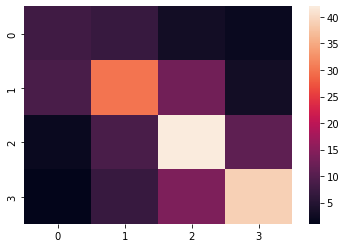

In [ ]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [ ]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [ ]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [ ]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [ ]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

In [ ]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[ 1.         -0.125       0.14285714  0.          0.4        -0.125
  -0.125      -0.5         0.          0.14285714]
 [-0.125       1.          0.14285714  0.          0.14285714  0.5
   0.         -0.5         0.          0.14285714]
 [ 0.14285714  0.14285714  1.          0.          0.          0.14285714
  -0.5        -0.28571429  0.          0.        ]
 [ 0.          0.          0.                 nan  0.          0.
   0.          0.          0.          0.        ]
 [ 0.4         0.14285714  0.          0.          1.          0.25
   0.25       -0.5         0.          0.5       ]
 [-0.125       0.5         0.14285714  0.          0.25        1.
   0.14285714 -0.28571429  0.          0.57142857]
 [-0.125       0.         -0.5         0.          0.25        0.14285714
   1.          0.14285714  0.          0.25      ]
 [-0.5        -0.5        -0.28571429  0.         -0.5        -0.28571429
   0.14285714  1.          0.         -0.28571429]
 [ 0.          0.          0.     

/usr/local/lib/python3.7/dist-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


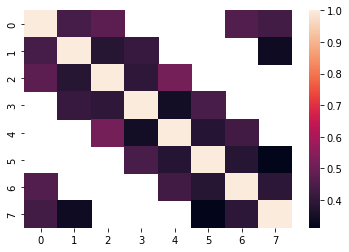

In [ ]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [ ]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [ ]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [ ]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

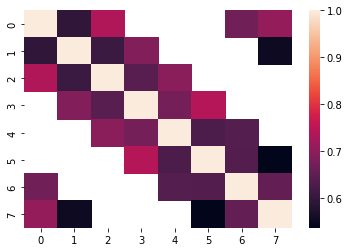

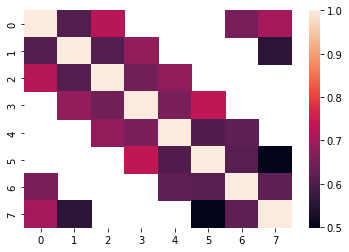

In [ ]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [ ]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/39937/files/6674661?wrap=1), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [ ]:
pwd

'/content/drive/MyDrive/Chicago/Academics/2022 Winter/Soci 40133 Content Analysis/Homework-Notebooks/data'

In [ ]:
#I tried using the Movies dataset from Week 5 breakout room discussion (18,968 movie transcripts from Mark Davies' Movies corpus with labels of genre: Action, Comedy, Crime, Drama, Horror, Romance)
#However, this did not really work because I could not get the pickle to work

import pandas as pd
import numpy as np
import scipy
import pickle
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

!pip3 install pickle5
import pickle5 as pickle


X_train = pd.read_pickle('../data/movies/movies_X_train.pickle')
X_test = pd.read_pickle('../data/movies/movies_X_test.pickle')
y_train = pd.read_pickle('../data/movies/movies_y_train.pickle')
y_test = pd.read_pickle('../data/movies/movies_y_test.pickle')

ValueError: ignored

In [ ]:
#For the purposes of this homework, I am using a manually coded dataset from three labelers
#They were tasked with judging if a product review was fake or not (on a scale of 1 to 5) for a series of randomly selected product on Amazon

x = np.array(
    [
     [2, 3, 5, 1, 2, 1, 4, 4, 3, 1],
     [2, 4, 4, 1, 2, 4, 5, 3, 3, 2],
     [4, 3, 4, 1, 3, 3, 3, 2, 3, 3]
    ]
)

anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [ ]:
anno.annotations

array([[1, 2, 4, 0, 1, 0, 3, 3, 2, 0],
       [1, 3, 3, 0, 1, 3, 4, 2, 2, 1],
       [3, 2, 3, 0, 2, 2, 2, 1, 2, 2]])

In [ ]:
anno.labels

[1, 2, 3, 4, 5]

In [ ]:
anno.missing_values

[]

In [ ]:
pyanno.measures.agreement.labels_frequency(anno.annotations, 5)

array([0.16666667, 0.2       , 0.33333333, 0.23333333, 0.06666667])

[[0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]]


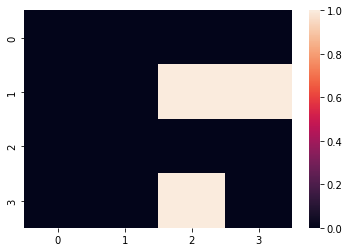

In [ ]:
#matrix of coded agreements between any two coders

c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [ ]:
#expected agreement calculated from the confusion matrix above
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

-0.49999999999999994

In [ ]:
#generalization of Scott's pi to n coders is Fleiss'  𝜅
fleiss_kappa(anno.annotations[::])

-0.030126336248785263

In [ ]:
#annotations as ordinally different
krippendorffs_alpha(anno.annotations[::])

-0.050899031811895146

In [ ]:
#possibility of agreement occurring by chance
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

-0.125

In [ ]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[ 1.         -0.125       0.14285714  0.          0.4        -0.125
  -0.125      -0.5         0.          0.14285714]
 [-0.125       1.          0.14285714  0.          0.14285714  0.5
   0.         -0.5         0.          0.14285714]
 [ 0.14285714  0.14285714  1.          0.          0.          0.14285714
  -0.5        -0.28571429  0.          0.        ]
 [ 0.          0.          0.                 nan  0.          0.
   0.          0.          0.          0.        ]
 [ 0.4         0.14285714  0.          0.          1.          0.25
   0.25       -0.5         0.          0.5       ]
 [-0.125       0.5         0.14285714  0.          0.25        1.
   0.14285714 -0.28571429  0.          0.57142857]
 [-0.125       0.         -0.5         0.          0.25        0.14285714
   1.          0.14285714  0.          0.25      ]
 [-0.5        -0.5        -0.28571429  0.         -0.5        -0.28571429
   0.14285714  1.          0.         -0.28571429]
 [ 0.          0.          0.     

/usr/local/lib/python3.7/dist-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


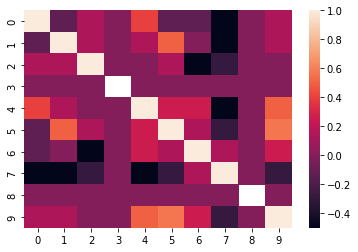

In [ ]:
ax = seaborn.heatmap(m)
plt.show()

In [ ]:
#average of Cohen's  𝜅  for all pairs of coders against each other
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.014047619047619041

In [ ]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

-0.19999999999999996

In [ ]:
#averaged over the total
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.005517075517075508

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


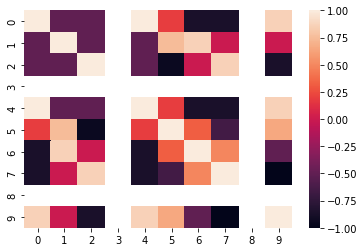

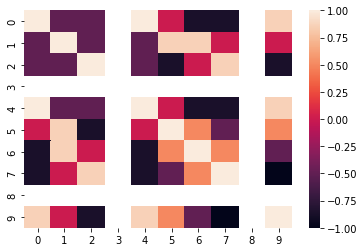

In [ ]:
#annotation as indicating real values to assess correlation of values (Pearson) and correlation of ranks (Spearman)
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

In [ ]:
#averaged over all comparable pairs
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

-0.1017755832830656 -0.10235805013515854


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [ ]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [ ]:
noise = .2

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [ ]:
dfTrain

So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [ ]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

In [ ]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [ ]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [ ]:
dir(sklearn)

Now we fit the model by giving it our training data

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [ ]:
dfTrain['vect']

And let's see what np.stack(dfTrain['vect']) does:

In [ ]:
np.stack(dfTrain['vect'])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

This lets us look at which classes do better:

In [ ]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

In [ ]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [ ]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(), test_size=.2)

In [ ]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Bayes
# clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

In [ ]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

In [ ]:
lucem_illud.plotregions(clf, dfTrain)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [ ]:
noise1 = .2
noise2 = .99

dfTrain1, dfTest1 = sklearn.model_selection.train_test_split(lucem_illud.random(), test_size=.2)
dfTrain2, dfTest2 = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise1), test_size=.2)
dfTrain3, dfTest3 = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise1), test_size=.2)
dfTrain4, dfTest4 = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise1), test_size=.2)
dfTrain5, dfTest5 = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise1), test_size=.2)

dfTrain6, dfTest6 = sklearn.model_selection.train_test_split(lucem_illud.random(), test_size=.2)
dfTrain7, dfTest7 = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise2), test_size=.2)
dfTrain8, dfTest8 = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise2), test_size=.2)
dfTrain9, dfTest9 = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise2), test_size=.2)
dfTrain10, dfTest10 = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise2), test_size=.2)

In [ ]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

In [ ]:
#Training machine learning algorithm

#Classical Regression
clf1 = sklearn.linear_model.LogisticRegression()

#Bayes
clf2 = sklearn.naive_bayes.GaussianNB()

#Analogizes
clf3 = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
clf4 = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf5 = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
clf6 = sklearn.tree.DecisionTreeClassifier()
clf7 = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf8 = sklearn.neural_network.MLPClassifier()

#Ensemble
clf9 = sklearn.ensemble.GradientBoostingClassifier()

In [ ]:
#Fitting the model by giving it training data
'''
clf[j].fit(np.stack(dfTrain1['vect'], axis=0), dfTrain[i]['category'])
clf.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clf.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clf.fit(np.stack(dfTrain5['vect'], axis=0), dfTrain5['category'])
clf.fit(np.stack(dfTrain6['vect'], axis=0), dfTrain6['category'])
clf.fit(np.stack(dfTrain7['vect'], axis=0), dfTrain7['category'])
clf.fit(np.stack(dfTrain8['vect'], axis=0), dfTrain8['category'])
clf.fit(np.stack(dfTrain9['vect'], axis=0), dfTrain9['category'])
clf.fit(np.stack(dfTrain10['vect'], axis=0), dfTrain10['category'])
'''

In [ ]:
#going through. the different models and dataset
classifiers = {}

for i in range(1,11):
    trainingData = locals()[f'dfTrain{i}']
    testData = locals()[f'dfTest{i}']
    for j in range(1,10):
        classifiers[f'classifier{j}data{i}'] = locals()[f'clf{j}']
        classifiers[f'classifier{j}data{i}'].fit(np.stack(trainingData['vect'], axis=0), trainingData['category'])
        print('')
        print(f'running classifier{j}data{i}')
        print(lucem_illud.evaluateClassifier(locals()[f'clf{j}'], testData))

#Interesting thoughts and observations:
#For Data1, K Neighbors seemed to best
#For Data2, neural network seemed to best
#For Data3, neural network seemed to best
#For Data4, linear SVM seemed to work best
#For Data5, naive Bayes seemed to work best
#For Data6, decision tree seemed to work best
#For Data7, linear SVM seemed to work best
#For Data8, K Neighbors seemed to best
#For Data9, K Neighbors seemed to best
#For Data10, neural network seemed to best


running classifier1data1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.45  0.553383   0.522124           0.504266  0.621053
1               0.45  0.553383   0.586207           0.554729  0.485714

running classifier2data1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.465  0.536591   0.509434           0.494573  0.568421
1              0.465  0.536591   0.563830           0.544600  0.504762

running classifier3data1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.455  0.546115   0.519231           0.500142  0.568421
1              0.455  0.546115   0.572917           0.550099  0.523810

running classifier4data1
          Error_Rate       AUC  Precision  A

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



running classifier8data3
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.09  0.910277   0.923077           0.885994  0.905660
1               0.09  0.910277   0.895833           0.859592  0.914894

running classifier9data3
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.125  0.876054   0.900990           0.848492  0.858491
1              0.125  0.876054   0.848485           0.808221  0.893617

running classifier1data4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.34  0.683838   0.576389           0.566559  0.922222
1               0.34  0.683838   0.875000           0.694773  0.445455

running classifier2data4
          Error_Rate       AUC  Precision  A

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



running classifier8data4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.09  0.915152   0.852941           0.839510  0.966667
1               0.09  0.915152   0.969388           0.912199  0.863636

running classifier9data4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.105  0.896465   0.863158           0.826433  0.911111
1              0.105  0.896465   0.923810           0.879632  0.881818


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



running classifier1data5
          Error_Rate       AUC  Precision  Average_Precision  Recall
Category                                                            
0              0.000  1.000000   1.000000           1.000000    1.00
1              0.002  0.995000   1.000000           0.992000    0.99
2              0.000  1.000000   1.000000           1.000000    1.00
3              0.002  0.998744   0.990291           0.990291    1.00
4              0.000  1.000000   1.000000           1.000000    1.00

running classifier2data5
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0                0.0  1.0        1.0                1.0     1.0
1                0.0  1.0        1.0                1.0     1.0
2                0.0  1.0        1.0                1.0     1.0
3                0.0  1.0        1.0                1.0     1.0
4                0.0  1.0        1.0                1.0     1.0

running classifi

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



running classifier1data10
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.164  0.761752   0.504673           0.386341  0.650602
1              0.176  0.740000   0.555556           0.413333  0.600000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.214  0.637127   0.525641           0.334156  0.369369
4              0.102  0.854888   0.769912           0.648056  0.776786

running classifier2data10
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.164  0.766577   0.504587           0.390365  0.662651
1              0.170  0.717500   0.582418           0.402681  0.530000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.194  0.691829   0.574468           0.393471  0.486486
4              0.100  0

Empirical data: newsgroups, senate small, senate large, spam

In [ ]:
#these cells took forever to run and would not load in the data
#but the process of seeing which model fits best would be similar as above
dfTrain1, dfTest1 = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), n=10)

KeyboardInterrupt: ignored

In [ ]:
dfTrain2, dfTest2 = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall())

In [ ]:
dfTrain3, dfTest3 = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge())

In [ ]:
dfTrain4, dfTest4 = sklearn.model_selection.train_test_split(lucem_illud.loadSpam())

In [ ]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

In [ ]:
#Training machine learning algorithm

#Classical Regression
clf1 = sklearn.linear_model.LogisticRegression()

#Bayes
clf2 = sklearn.naive_bayes.GaussianNB()

#Analogizes
clf3 = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
clf4 = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf5 = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
clf6 = sklearn.tree.DecisionTreeClassifier()
clf7 = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf8 = sklearn.neural_network.MLPClassifier()

#Ensemble
clf9 = sklearn.ensemble.GradientBoostingClassifier()

In [ ]:
#going through. the different models and dataset
classifiers = {}

for i in range(1,11):
    trainingData = locals()[f'dfTrain{i}']
    testData = locals()[f'dfTest{i}']
    for j in range(1,10):
        classifiers[f'classifier{j}data{i}'] = locals()[f'clf{j}']
        classifiers[f'classifier{j}data{i}'].fit(np.stack(trainingData['vect'], axis=0), trainingData['category'])
        print('')
        print(f'running classifier{j}data{i}')
        print(lucem_illud.evaluateClassifier(locals()[f'clf{j}'], testData))

#seeing which model had the best precision

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [ ]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame. 

In [ ]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [ ]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [ ]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [ ]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Let's split the data into training data and testing data.

In [ ]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [ ]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [ ]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1. 

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform. 

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [ ]:
TFVects.shape

(1367, 11152)

We can save this in the dataframe to make things easier

In [ ]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [ ]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [ ]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


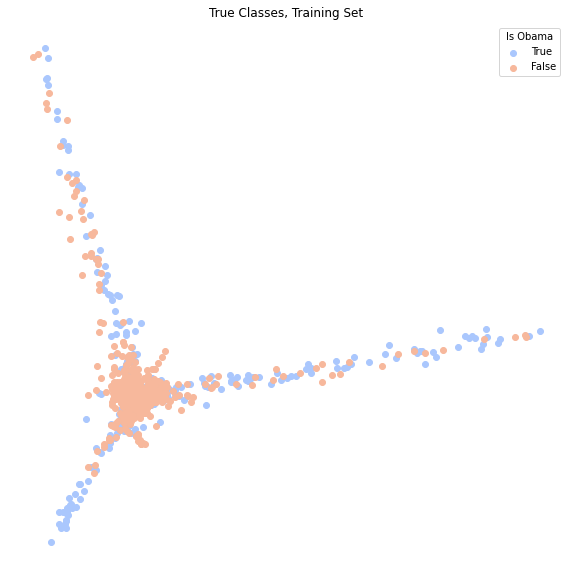

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

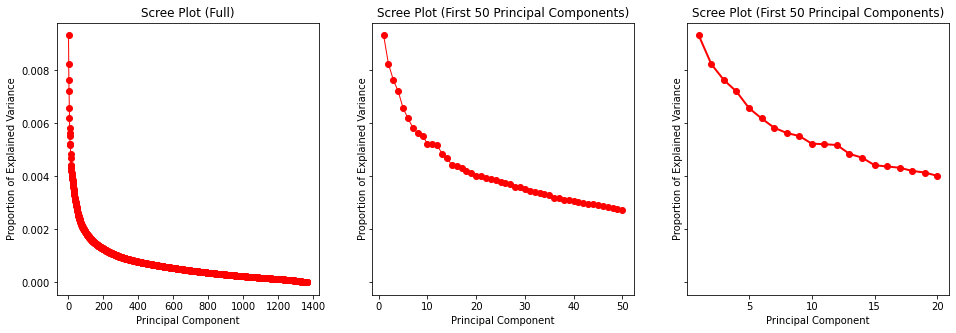

In [ ]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [ ]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [ ]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [ ]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6664228237015362

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [ ]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6403508771929824

Slightly poorer. How about using more dimensions (40)?

In [ ]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7439648866130212
Testing:
0.7134502923976608


Or still more (100)?

In [ ]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.825164594001463
Testing:
0.7748538011695907


Or even more (200)!

In [ ]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8675932699341624
Testing:
0.804093567251462


This is becoming ridiculous (400)!

In [ ]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9070958302852963
Testing:
0.8421052631578947


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [ ]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9553767373811266


Train the model using training data, and then test it on the testing data.

In [ ]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8450292397660819


81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [ ]:
#my final project dataset on three journals of higher education from 1930 to 1950 
#might not be most suitable for supervised learning methods of analysis
#for the purposes of this homework, I will attempt to assess whether the reporting of higher education changed after the Second World War

In [ ]:
#read the json file into panda dataframe
import pandas as pd
df = pd.read_json('education_corpora.jsonl', lines=True)

jstorSample = df.sample(n=3500)

jstorCategories = ['The School Review', 'The Journal of Higher Education', 'Review of Educational Research']

for category in jstorCategories:
  for index, row in jstorSample.iterrows():
      for key in row['unigramCount']:
          sentence = ""
          value = row['unigramCount'][key]
          for i in range(value):
              sentence = sentence + key + ""
      jstorSample.loc[index, 'text'] = sentence

jstorSample['category'] = jstorSample['isPartOf']

In [ ]:
#Apply our functions, notice each row is a list of lists now
jstorSample['tokenized_sents'] = jstorSample['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
#jstorSample['normalized_sents'] = jstorSample['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])
jstorSample['normalized_sents'] = jstorSample['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

In [ ]:
jstorSample

,creator,datePublished,docSubType,docType,id,identifier,isPartOf,issueNumber,language,outputFormat,pageCount,pageEnd,pageStart,pagination,provider,publicationYear,publisher,sourceCategory,tdmCategory,title,url,volumeNumber,wordCount,unigramCount,bigramCount,trigramCount,text,category,tokenized_sents,normalized_sents
5922,"[Virginia F. Matson, Paul R. Pierce]",1946-02-01,research-article,article,http://www.jstor.org/stable/1082612,"[{'name': 'issn', 'value': '00366773'}, {'name...",The School Review,2,[eng],"[unigram, bigram, trigram]",7,89,83,pp. 83-89,jstor,1946,University of Chicago Press,"[Education, Social Sciences]",[Education - Specialized education],Science in the Core Curriculum,http://www.jstor.org/stable/1082612,54,3193,"{'""Meeting': 1, 'services': 1, 'remains': 1, '...","{'third-year boy': 1, 'Responsibilities."" Each...","{'cases, and filled': 1, 'more classes in': 1,...",clinics,The School Review,[[clinics]],[[clinic]]
5487,[Roy A. Price],1936-04-01,book-review,article,http://www.jstor.org/stable/1080259,"[{'name': 'issn', 'value': '00366773'}, {'name...",The School Review,4,[eng],"[unigram, bigram, trigram]",2,308,307,pp. 307-308,jstor,1936,University of Chicago Press,"[Education, Social Sciences]",NaN,The Evolution of the Social Sciences in the Sc...,http://www.jstor.org/stable/1080259,44,654,"{'interest': 1, 'extent': 1, 'find': 1, 'namel...","{'elementary-school and': 1, 'REVIEW [April': ...","{'and Henry Johnson': 1, 'past."" Roy A.': 1, '...",REVIEW,The School Review,[[REVIEW]],[[review]]
1668,"[Willard B. Spalding, William C. Kvaraceus]",1943-12-01,research-article,article,http://www.jstor.org/stable/1081310,"[{'name': 'issn', 'value': '00366773'}, {'name...",The School Review,10,[eng],"[unigram, bigram, trigram]",4,613,610,pp. 610-613,jstor,1943,University of Chicago Press,"[Education, Social Sciences]",[Philosophy - Applied philosophy],The Secondary Schools in Transition: 1635-1943,http://www.jstor.org/stable/1081310,51,1871,"{'and': 60, 'past': 2, 'fascism': 1, 'who': 9,...","{'future prospects': 1, 'or out-': 1, 'leader-...","{'and its energies': 1, 'to ar- rive': 1, 'in ...",WeWeWeWeWe,The School Review,[[WeWeWeWeWe]],[[wewewewewe]]
6276,[H. A. Basilius],1945-12-01,research-article,article,http://www.jstor.org/stable/1976980,"[{'name': 'issn', 'value': '00221546'}, {'name...",The Journal of Higher Education,9,[eng],"[unigram, bigram, trigram]",7,478,472,pp. 472-478,jstor,1945,Ohio State University Press,"[Education, Social Sciences]",[Arts - Literature],An Open Letter Addressed to the Dean of an Art...,http://www.jstor.org/stable/1976980,16,3290,"{'sterile': 1, 'would,': 1, 'member': 3, 'disc...","{'the three-part': 1, 'the record': 1, 'We sho...","{'by the class': 2, 'to translate sound': 1, '...",form.form.,The Journal of Higher Education,[[form.form]],[[form.form]]
251,NaN,1949-02-01,misc,article,http://www.jstor.org/stable/1082296,"[{'name': 'issn', 'value': '00366773'}, {'name...",The School Review,2,[eng],"[unigram, bigram, trigram]",18,121,104,pp. 104-121,jstor,1949,University of Chicago Press,"[Education, Social Sciences]",[Education - Formal education],Selected References on Secondary-School Instru...,http://www.jstor.org/stable/1082296,57,8487,"{'Learners,""': 1, 'Dynamics,""': 1, '217.': 1, ...","{'School Mathe-': 1, 'Language Journal,': 11, ...","{'for challenging the': 1, 'the United Nations...",Effective,The School Review,[[Effective]],[[effective]]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,[Pedro T. Orata],1937-03-01,research-article,article,http://www.jstor.org/stable/1974613,"[{'name': 'issn', 'value': '00221546'}, {'name...",The Journal of Higher Education,3,[eng],"[unigram, bigram, trigram]",9,158,150,pp. 150-158,jstor,1937,Ohio State University Press,"[Education, Social Sciences]",[Business - Business administration],The Problem Professor of Education,http://www.jstor.org/stable/1974613,8,4332,"{

In [ ]:
jstorSample['year'] = pd.to_numeric(jstorSample.datePublished.str[:4])

In [ ]:
jstorSample['label'] = np.where((jstorSample['year'] > 1949), True)

ValueError: ignored

In [ ]:
#splitting the corpus data into training set and holdout set
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(jstorSample, holdBackFraction=holdBackFraction)

In [ ]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

In [ ]:
TFVects.shape

(2800, 331)

In [ ]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [ ]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

In [ ]:
train_data_df['pca'] = [r for r in reduced_data]

KeyError: ignored

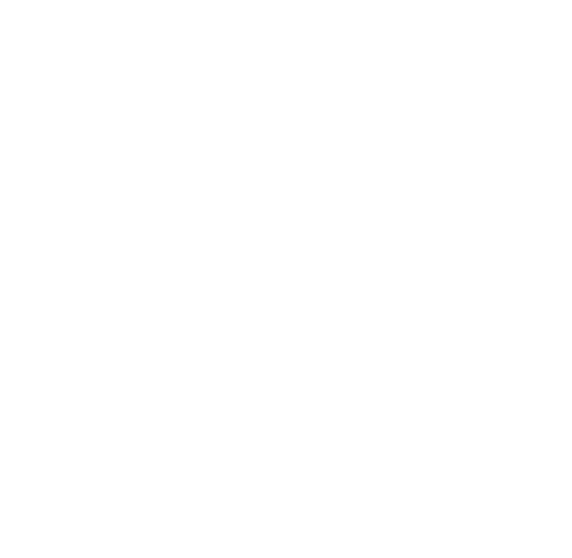

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot after
a = np.stack(train_data_df[train_data_df['datePublished']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot before
a = np.stack(train_data_df[train_data_df['datePublished'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is After')
plt.title('True Classes, Training Set')
plt.show()

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

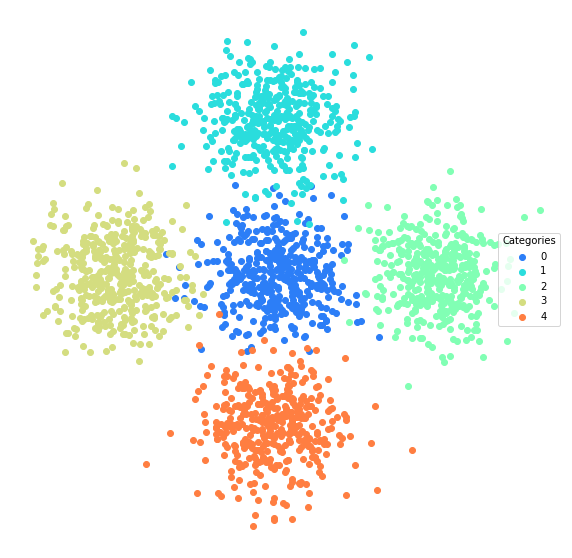

In [ ]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [ ]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification: 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

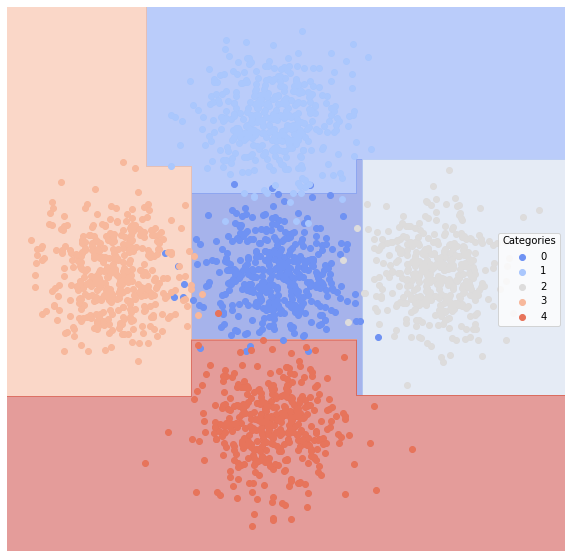

In [ ]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [ ]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.036,0.946746,0.900000,0.842531,0.918367
1,0.012,0.977104,0.979167,0.947201,0.959184
2,0.012,0.981250,0.970000,0.946900,0.970000
3,0.008,0.987108,0.979167,0.962767,0.979167
4,0.008,0.988190,0.981481,0.967306,0.981481


Lets look at accuracy:

In [ ]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.962

What happens if we trim the tree?

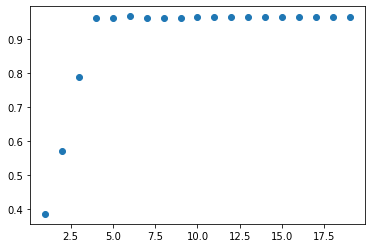

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

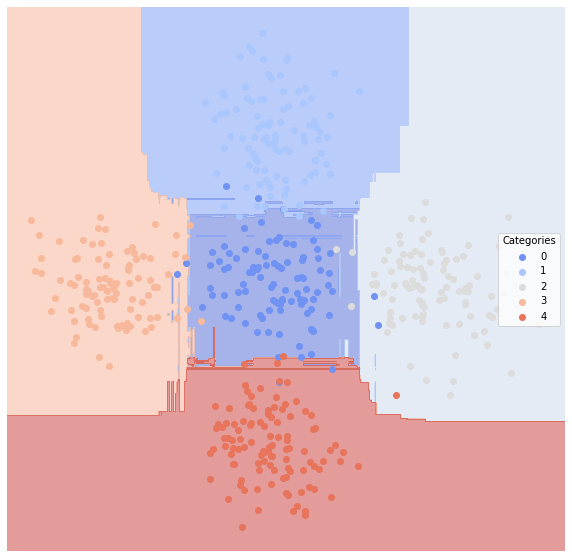

In [ ]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [ ]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.036,0.950604,0.892157,0.842431,0.928571
1,0.012,0.977104,0.979167,0.947201,0.959184
2,0.012,0.981250,0.970000,0.946900,0.970000
3,0.008,0.987108,0.979167,0.962767,0.979167
4,0.008,0.984836,0.990566,0.969050,0.972222


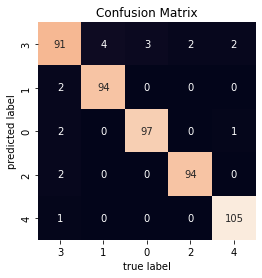

In [ ]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [ ]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['label'])

#though I was not able to convert the data for my final project in a format that could work with supervised learning methods
#I took a try at answering this question and writing out what code I would use to analyze it with decision tree and random forest models

KeyError: ignored

In [ ]:
#tree plot
lucem_illud.plotregions(clf_tree, train_data_df)

#evaluating decisino tree model
lucem_illud.evaluateClassifier(clf_tree, test_data_df)
sklearn.metrics.accuracy_score(test_data_df['label'],clf_tree.predict(np.stack(test_data_df['vect'], axis = 0)))

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['label'])
    score = sklearn.metrics.accuracy_score(test_data_df['label'], tree2.predict(np.stack(test_data_df['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=5)

#bagging decision trees together for random forest, where each tree uses up to 70% of the data
bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.7, random_state=1)

#fit the bagged classifier
bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['label'])

#plot the random forest model
lucem_illud.plotregions(bag, test_data_df)

#evaluate random forest model
lucem_illud.evaluateClassifier(bag, test_data_df)

#using confusion matrix
lucem_illud.plotConfusionMatrix(bag, test_data_df)

#what is accuracy?
lucem_illud.plotMultiROC(bag, test_data_df)

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [ ]:
newsgroupsDF[:5]

Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Let's produce another confusion matrix:

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [ ]:
#Similarly as Exercise 4, though I was not able to convert the data for my final project in a format that could work with supervised learning methods
#I took a try at answering this question and writing out what code I would use to analyze it with decision tree and random forest models

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [ ]:
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['label'])

KeyError: ignored

In [ ]:
#evaluating K nearest neighbors classifier
lucem_illud.evaluateClassifier(clf_knearest, train_data_df)

#using confusion matrix
lucem_illud.plotConfusionMatrix(clf_knearest, test_data_df)

#what is accuracy?
lucem_illud.plotMultiROC(clf_knearest, test_data_df)

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

In [ ]:
#Similarly as Exercise 4 and 5, though I was not able to convert the data for my final project in a format that could work with supervised learning methods
#I took a try at answering this question and writing out what code I would use to analyze it with decision tree and random forest models

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['label'])

KeyError: ignored

In [ ]:
#evaluating neural networks classifier
lucem_illud.evaluateClassifier(clf_neural_network, train_data_df)

#using confusion matrix
lucem_illud.plotConfusionMatrix(clf_neural_network, test_data_df)

#what is accuracy?
lucem_illud.plotMultiROC(clf_neural_network, test_data_df)

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [run_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_glue.py) and
[run_pl_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_pl_glue.py) or
[run_tf_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_tf_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [ ]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_squad.py) and
[run_tf_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_tf_squad.py) scripts.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/question-answering/run_squad.py script.
"""

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [122]:
jstorSample

,creator,datePublished,docSubType,docType,id,identifier,isPartOf,issueNumber,language,outputFormat,pageCount,pageEnd,pageStart,pagination,provider,publicationYear,publisher,sourceCategory,tdmCategory,title,url,volumeNumber,wordCount,unigramCount,bigramCount,trigramCount,text,category,tokenized_sents,normalized_sents,year
5922,"[Virginia F. Matson, Paul R. Pierce]",1946-02-01,research-article,article,http://www.jstor.org/stable/1082612,"[{'name': 'issn', 'value': '00366773'}, {'name...",The School Review,2,[eng],"[unigram, bigram, trigram]",7,89,83,pp. 83-89,jstor,1946,University of Chicago Press,"[Education, Social Sciences]",[Education - Specialized education],Science in the Core Curriculum,http://www.jstor.org/stable/1082612,54,3193,"{'""Meeting': 1, 'services': 1, 'remains': 1, '...","{'third-year boy': 1, 'Responsibilities."" Each...","{'cases, and filled': 1, 'more classes in': 1,...",clinics,The School Review,[[clinics]],[[clinic]],1946
5487,[Roy A. Price],1936-04-01,book-review,article,http://www.jstor.org/stable/1080259,"[{'name': 'issn', 'value': '00366773'}, {'name...",The School Review,4,[eng],"[unigram, bigram, trigram]",2,308,307,pp. 307-308,jstor,1936,University of Chicago Press,"[Education, Social Sciences]",NaN,The Evolution of the Social Sciences in the Sc...,http://www.jstor.org/stable/1080259,44,654,"{'interest': 1, 'extent': 1, 'find': 1, 'namel...","{'elementary-school and': 1, 'REVIEW [April': ...","{'and Henry Johnson': 1, 'past."" Roy A.': 1, '...",REVIEW,The School Review,[[REVIEW]],[[review]],1936
1668,"[Willard B. Spalding, William C. Kvaraceus]",1943-12-01,research-article,article,http://www.jstor.org/stable/1081310,"[{'name': 'issn', 'value': '00366773'}, {'name...",The School Review,10,[eng],"[unigram, bigram, trigram]",4,613,610,pp. 610-613,jstor,1943,University of Chicago Press,"[Education, Social Sciences]",[Philosophy - Applied philosophy],The Secondary Schools in Transition: 1635-1943,http://www.jstor.org/stable/1081310,51,1871,"{'and': 60, 'past': 2, 'fascism': 1, 'who': 9,...","{'future prospects': 1, 'or out-': 1, 'leader-...","{'and its energies': 1, 'to ar- rive': 1, 'in ...",WeWeWeWeWe,The School Review,[[WeWeWeWeWe]],[[wewewewewe]],1943
6276,[H. A. Basilius],1945-12-01,research-article,article,http://www.jstor.org/stable/1976980,"[{'name': 'issn', 'value': '00221546'}, {'name...",The Journal of Higher Education,9,[eng],"[unigram, bigram, trigram]",7,478,472,pp. 472-478,jstor,1945,Ohio State University Press,"[Education, Social Sciences]",[Arts - Literature],An Open Letter Addressed to the Dean of an Art...,http://www.jstor.org/stable/1976980,16,3290,"{'sterile': 1, 'would,': 1, 'member': 3, 'disc...","{'the three-part': 1, 'the record': 1, 'We sho...","{'by the class': 2, 'to translate sound': 1, '...",form.form.,The Journal of Higher Education,[[form.form]],[[form.form]],1945
251,NaN,1949-02-01,misc,article,http://www.jstor.org/stable/1082296,"[{'name': 'issn', 'value': '00366773'}, {'name...",The School Review,2,[eng],"[unigram, bigram, trigram]",18,121,104,pp. 104-121,jstor,1949,University of Chicago Press,"[Education, Social Sciences]",[Education - Formal education],Selected References on Secondary-School Instru...,http://www.jstor.org/stable/1082296,57,8487,"{'Learners,""': 1, 'Dynamics,""': 1, '217.': 1, ...","{'School Mathe-': 1, 'Language Journal,': 11, ...","{'for challenging the': 1, 'the United Nations...",Effective,The School Review,[[Effective]],[[effective]],1949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,[Pedro T. Orata],1937-03-01,research-article,article,http://www.jstor.org/stable/1974613,"[{'name': 'issn', 'value': '00221546'}, {'name...",The Journal of Higher Education,3,[eng],"[unigram, bigram, trigram]",9,158,150,pp. 150-158,jstor,1937,Ohio State University Press,"[Education, Social Sciences]",[Business - Business administration],The Problem Professor of Education,http://www.

In [123]:
#the BERT pipelines did not seem to work with my data corpus
#I was trying to use it to explore the tension in the goal of higher education: a general development of the mind v.s. pragmatic and pre-professional

from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("grade", "technical", "professional")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("education", "interest", "learning")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

ModuleNotFoundError: ignored

In [ ]:
result = nlp(question="What is the goal of higher education?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")